# Frequentism and Bayesianism II: When Results Differ

**Mario Juric & Jake VanderPlas, University of Washington**

**e-mail: <mjuric@astro.washington.edu>, twitter: [@mjuric](http://twitter.com/mjuric)**

---

*This lecture is based on a [post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) on the blog [Pythonic Perambulations](http://jakevdp.github.io), by [Jake VanderPlas](https://staff.washington.edu/jakevdp/). The content is BSD licensed. See also VanderPlas (2014) ["Frequentism and Bayesianism: A Python-driven Primer"](http://arxiv.org/abs/1411.5018).*

*Slides built using the excellent [RISE](https://github.com/damianavila/RISE) Jupyter extension by [Damian Avila](https://github.com/damianavila).*

We just showed that Bayesian and Frequentist approaches are often equivalent for simple problems. But it is also true that they can diverge greatly for more complicated problems. In practice, this divergence makes itself most clear in two different situations:

1. The handling of "nuisance parameters"
2. The subtle (and often overlooked) difference between frequentist confidence intervals and Bayesian credible intervals

The second point is a bit more involved, and we'll save it for the end. Here, we focus on the first point: the difference between frequentist and Bayesian treatment of nuisance parameters.

## What is a Nuisance Parameter?

***A nuisance parameter is any quantity whose value is not relevant to the goal of an analysis, but is nevertheless required to determine some quantity of interest***.

For example, in the [second application](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/#Varying-Photon-Counts:-The-Bayesian-Approach) worked-through in the previous part, we estimated both the mean $\mu$ and intrinsic scatter $\sigma$ for the observed photons. In practice, we may only be interested in $\mu$, the mean of the distribution. In this case $\sigma$ is a nuisance parameter: it is not of immediate interest, but is nevertheless an essential stepping-stone in determining the final estimate of $\mu$, the parameter of interest.

To illustrate this, we're going to go through two examples where nuisance parameters come into play. We'll explore both the frequentist and the Bayesian approach to solving both of these problems:

## Example #1: The Bayesian Billiard Game

We'll start with an example of nuisance parameters that, in one form or another, dates all the way back to the posthumous [1763 paper](http://www.stat.ucla.edu/history/essay.pdf) written by Thomas Bayes himself. The particular version of this problem we'll study is borrowed from [Eddy 2004](ftp://selab.janelia.org/pub/publications/Eddy-ATG3/Eddy-ATG3-reprint.pdf).

The setting is a rather contrived game in which Alice and Bob bet on the outcome of a process they can't directly observe:

> Alice and Bob enter a room. Behind a curtain there is a billiard table, which they cannot see, but their friend Carol can. Carol rolls a ball down the table, and marks where it lands. Once this mark is in place, Carol begins rolling new balls down the table. If the ball lands to the left of the mark, Alice gets a point; if it lands to the right of the mark, Bob gets a point.  We can assume for the sake of example that Carol's rolls are unbiased: that is, the balls have an equal chance of ending up anywhere on the table.  The first person to reach **six points** wins the game.

Here ***the location of the mark (determined by the first roll) can be considered a nuisance parameter***.

It is unknown, and not of immediate interest, but it clearly must be accounted for when predicting the outcome of subsequent rolls. If the first roll settles far to the right, then subsequent rolls will favor Alice. If it settles far to the left, Bob will be favored instead.

Given this setup, here is the question we ask of ourselves:

> In a particular game, after eight rolls, Alice has five points and Bob has three points. What is the probability that Bob will go on to win the game?

Intuitively, you probably realize that because Alice received five of the eight points, the marker placement likely favors her. And given this, it's more likely that the next roll will go her way as well. And she has three opportunities to get a favorable roll before Bob can win; she seems to have clinched it.  But, **quantitatively**, what is the probability that Bob will squeak-out a win?

### A Naïve Frequentist Approach

Someone following a classical frequentist approach might reason as follows:

To determine the result, we need an intermediate estimate of where the marker sits. We'll quantify this marker placement as a probability $p$ that any given roll lands in Alice's favor.  Because five balls out of eight fell on Alice's side of the marker, we can quickly show that the maximum likelihood estimate of $p$ is given by:

$$
\hat{p} = 5/8
$$

(This result follows in a straightforward manner from the [binomial likelihood](http://en.wikipedia.org/wiki/Binomial_distribution)). Assuming this maximum likelihood probability, we can compute the probability that Bob will win, which is given by:

$$
P(B) = (1 - \hat{p})^3
$$

That is, he needs to win three rolls in a row.

Thus, we find that the following estimate of the probability:

In [1]:
p_hat = 5. / 8.
freq_prob = (1 - p_hat) ** 3
print("Naïve Frequentist Probability of Bob Winning: {0:.2f}".format(freq_prob))

Naïve Frequentist Probability of Bob Winning: 0.05


In other words, we'd give Bob the following odds of winning:

In [2]:
print("Odds against Bob winning: {0:.0f} to 1".format((1. - freq_prob) / freq_prob))

Odds against Bob winning: 18 to 1


So we've estimated using frequentist ideas that Alice will win about 18 times for each time Bob wins. Let's try a Bayesian approach next.

### Bayesian Approach

We can also approach this problem from a Bayesian standpoint. This is slightly more involved, and requires us to first define some notation.

We'll consider the following random variables:

- $B$ = Bob Wins
- $D$ = observed data, i.e. $D = (n_A, n_B) = (5, 3)$
- $p$ = unknown probability that a ball lands on Alice's side during the current game

We want to compute $P(B~|~D)$; that is, the probability that Bob wins given our observation that Alice currently has five points to Bob's three.

The general Bayesian method of treating nuisance parameters is ***marginalization***, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution
$$
P(B,p~|~D)
$$
and then marginalize over $p$ using the following identity:
$$
P(B~|~D) \equiv \int_{-\infty}^\infty P(B,p~|~D) {\mathrm d}p
$$
This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $P(p)$ as being a measure of uncertainty of our own knowledge.

#### Building our Bayesian Expression

To compute this result, we will manipulate the above expression for $P(B~|~D)$ until we can express it in terms of other quantities that we can compute.

We'll start by applying the following definition of [conditional probability](http://en.wikipedia.org/wiki/Conditional_probability#Definition) to expand the term $P(B,p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) P(p~|~D) dp
$$

Next we use [Bayes' rule](http://en.wikipedia.org/wiki/Bayes%27_theorem) to rewrite $P(p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) \frac{P(D~|~p)P(p)}{P(D)} dp
$$

Finally, using the same probability identity we started with, we can expand $P(D)$ in the denominator to find:

$$
P(B~|~D) = \frac{\int P(B~|~p,D) P(D~|~p) P(p) dp}{\int P(D~|~p)P(p) dp}
$$

Now the desired probability is expressed in terms of three quantities that we can compute. Let's look at each of these in turn:
<small>
- $P(B~|~p,D)$: This term is exactly the frequentist likelihood we used above. In words: given a marker placement $p$ and the fact that Alice has won 5 times and Bob 3 times, what is the probability that Bob will go on to six wins?  Bob needs three wins in a row, i.e. $P(B~|~p,D) = (1 - p) ^ 3$.
- $P(D~|~p)$: this is another easy-to-compute term. In words: given a probability $p$, what is the likelihood of exactly 5 positive outcomes out of eight trials? The answer comes from the well-known [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution): in this case $P(D~|~p) \propto p^5 (1-p)^3$
- $P(p)$: this is our prior on the probability $p$. By the problem definition, we can assume that $p$ is evenly drawn between 0 and 1.  That is, $P(p) \propto 1$, and the integrals range from 0 to 1.</small>

Putting this all together, canceling some terms, and simplifying a bit, we find
$$
P(B~|~D) = \frac{\int_0^1 (1 - p)^6 p^5 dp}{\int_0^1 (1 - p)^3 p^5 dp}
$$
where both integrals are evaluated from 0 to 1.

These integrals might look a bit difficult, until we notice that they are special cases of the [Beta Function](http://en.wikipedia.org/wiki/Beta_function):
$$
\beta(n, m) = \int_0^1 (1 - p)^{n - 1} p^{m - 1}
$$

We'll compute these directly using Scipy's beta function implementation:

In [3]:
from scipy.special import beta
bayes_prob = beta(6 + 1, 5 + 1) / beta(3 + 1, 5 + 1)

print("P(B|D) = {0:.2f}".format(bayes_prob))

P(B|D) = 0.09


The associated odds are the following:

In [4]:
print("Bayesian odds against Bob winning: {0:.0f} to 1".format((1. - bayes_prob) / bayes_prob))

Bayesian odds against Bob winning: 10 to 1


So we see that the Bayesian result gives us 10 to 1 odds, which is quite different than the 18 to 1 odds found using the frequentist approach. So which one is correct?

### A Brute Force/Monte Carlo Approach

For this type of well-defined and simple setup, it is actually relatively easy to use a Monte Carlo simulation to determine the correct answer. This is essentially a brute-force tabulation of possible outcomes: we generate a large number of random games, and simply count the fraction of relevant games that Bob goes on to win. The current problem is especially simple because so many of the random variables involved are uniformly distributed. 

We can use the ``numpy`` package to do this as follows:

In [5]:
import numpy as np
np.random.seed(0)

# play 100000 games with randomly-drawn p, between 0 and 1
p = np.random.random(100000)

# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, len(p)))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < p, 0)
Bob_count = np.cumsum(rolls >= p, 0)

# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

# determine number of games which meet our criterion of (A wins, B wins)=(5, 3)
# this means Bob's win count at eight rolls must equal 3
good_games = Bob_count[7] == 3
print("Number of suitable games: {0}".format(good_games.sum()))

# truncate our results to consider only these games
Alice_count = Alice_count[:, good_games]
Bob_count = Bob_count[:, good_games]

# determine which of these games Bob won.
# to win, he must reach six wins after 11 rolls.
bob_won = np.sum(Bob_count[10] == 6)
print("Number of these games Bob won: {0}".format(bob_won.sum()))

# compute the probability
mc_prob = bob_won.sum() * 1. / good_games.sum()
print("Monte Carlo Probability of Bob winning: {0:.2f}".format(mc_prob))
print("MC Odds against Bob winning: {0:.0f} to 1".format((1. - mc_prob) / mc_prob))

(Sanity check passed)
Number of suitable games: 11068
Number of these games Bob won: 979
Monte Carlo Probability of Bob winning: 0.09
MC Odds against Bob winning: 10 to 1


The Monte Carlo approach gives 10-to-1 odds on Bob, which agrees with the Bayesian approach.

Apparently, our naïve frequentist approach above was flawed.

### Discussion

This example shows several different approaches to dealing with the presence of a nuisance parameter *p*. The Monte Carlo simulation gives us a close brute-force estimate of the true probability (assuming the validity of our assumptions), which the Bayesian approach matches. The naïve frequentist approach, by utilizing a single maximum likelihood estimate of the nuisance parameter $p$, arrives at the wrong result.

**This does not imply frequentism itself is incorrect**. The incorrect result above is more a matter of the approach being "naïve" than it being "frequentist". There certainly exist frequentist methods for handling this sort of nuisance parameter – for example, it is theoretically possible to apply a transformation and conditioning of the data to isolate the dependence on $p$ (though it's difficult to find any approach to this particular problem that does not somehow take advantage of Bayesian-like marginalization over $p$).

Another potential point of contention is that the question itself is posed in a way that is perhaps unfair to the classical, frequentist approach. A frequentist might instead hope to give the answer in terms of null tests or confidence intervals: that is, they might devise a procedure to construct limits which would provably bound the correct answer in $100\times(1 - p)$ percent of similar trials, for some value of $p$ – say, 0.05 (note this is a different $p$ than the $p$ we've been talking about above). ***This might be classically accurate, but it doesn't quite answer the question at hand***!

(note: more on this later...)

***There is one clear common point of these two potential frequentist responses: both require some degree of effort and/or special expertise;*** perhaps a suitable frequentist approach would be immediately obvious to someone with a PhD in statistics, but is most definitely *not* obvious to a statistical lay-person simply trying to answer the question at hand.

In this sense, Bayesianism provides a better approach for this sort of problem: by simple algebraic manipulation of a few well-known axioms of probability within a Bayesian framework, we can straightforwardly arrive at the correct answer without need for other special expertise.

We'll explore a more data-oriented example of dealing with nuisance parameters next.

## Example #2: Linear Fit with Outliers

One situation where the concept of nuisance parameters can be helpful is accounting for outliers in data. Consider the following dataset, relating the observed variables $x$ and $y$, and the error of $y$ stored in $e$.

In [6]:
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

We'll visualize this data below:

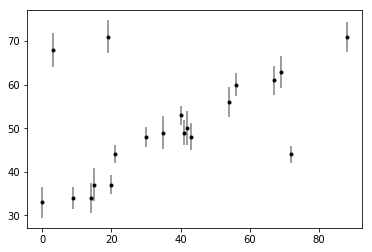

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.errorbar(x, y, e, fmt='.k', ecolor='gray');

Our task is to find a line of best-fit to the data. It's clear upon visual inspection that there are some outliers among these points, but let's start with a simple non-robust maximum likelihood approach. Like we saw in the previous post, the following simple maximum likelihood result can be considered to be either frequentist or Bayesian (with uniform priors): in this sort of simple problem, the approaches are essentially equivalent.

We'll propose a simple linear model, which has a slope and an intercept encoded in a parameter vector $\theta$. The model is defined as follows:
$$
\hat{y}(x~|~\theta) = \theta_0 + \theta_1 x
$$

Given this model, we can compute a Gaussian likelihood for each point:
$$
p(x_i,y_i,e_i~|~\theta) \propto \exp\left[-\frac{1}{2e_i^2}\left(y_i - \hat{y}(x_i~|~\theta)\right)^2\right]
$$
The total likelihood is the product of all the individual likelihoods. Computing this and taking the log, we have:
$$
\log \mathcal{L}(D~|~\theta) = \mathrm{const} - \sum_i \frac{1}{2e_i^2}\left(y_i - \hat{y}(x_i~|~\theta)\right)^2
$$

This should all look pretty familiar. This final expression is the log-likelihood of the data given the model, which can be maximized to find the $\theta$ corresponding to the maximum-likelihood model. Equivalently, we can minimize the summation term, which is known as the *loss*:
$$
\mathrm{loss} = \sum_i \frac{1}{2e_i^2}\left(y_i - \hat{y}(x_i~|~\theta)\right)^2
$$
This loss expression is known as a *squared loss*; here we've simply shown that the squared loss can be derived from the Gaussian log likelihood.

### Standard Likelihood Approach

Following the logic of the previous post, we can maximize the likelihood (or, equivalently, minimize the loss) to find $\theta$ within a frequentist paradigm. For a flat prior in $\theta$, the maximum of the Bayesian posterior will yield the same result.

(note that there are good arguments based on the principle of maximum entropy that a flat prior is not the best choice here; we'll ignore that detail for now, as it's a very small effect for this problem).

For simplicity, we'll use scipy's ``optimize`` package to minimize the loss:

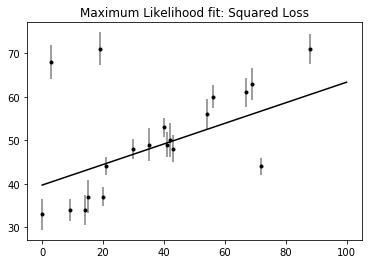

In [8]:
from scipy import optimize

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss');

It's clear on examination that the outliers are exerting a disproportionate influence on the fit. This is due to the nature of the squared loss function. If you have a single outlier that is, say 10 standard deviations away from the fit, its contribution to the loss will out-weigh that of 25 points which are 2 standard deviations away!

Clearly the squared loss is overly sensitive to outliers, and this is causing issues with our fit. One way to address this within the frequentist paradigm is to simply adjust the loss function to be more robust.

### Frequentist Correction for Outliers: Huber Loss

The variety of possible loss functions is quite literally infinite, but one relatively well-motivated option is the [Huber loss](http://en.wikipedia.org/wiki/Huber_loss_function). The Huber loss defines a critical value at which the loss curve transitions from quadratic to linear. Let's create a plot which compares the Huber loss to the standard squared loss for several critical values $c$:

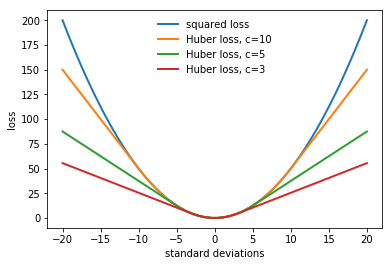

In [9]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

plt.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label="Huber loss, c={0}".format(c), lw=2)
plt.ylabel('loss')
plt.xlabel('standard deviations')
plt.legend(loc='best', frameon=False);

The Huber loss is equivalent to the squared loss for points which are well-fit by the model, but reduces the loss contribution of outliers. For example, a point 20 standard deviations from the fit has a squared loss of 200, but a c=3 Huber loss of just over 55. Let's see the result of the best-fit line using the Huber loss rather than the squared loss. We'll plot the squared loss result in light gray for comparison:

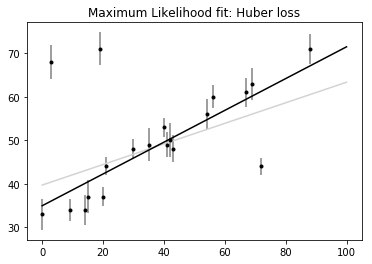

In [10]:
def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

By eye, this seems to have worked as desired: the fit is much closer to our intuition!

However a Bayesian might point out that the motivation for this new loss function is a bit suspect: as we showed, the squared-loss can be straightforwardly derived from a Gaussian likelihood. The Huber loss seems a bit *ad hoc*: where does it come from? How should we decide what value of $c$ to use? Is there any good motivation for using a linear loss on outliers, or should we simply remove them instead? How might this choice affect our resulting model?

### A Bayesian Approach to Outliers: Nuisance Parameters

The Bayesian approach to accounting for outliers generally involves *modifying the model* so that the outliers are accounted for. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers.

One option is to choose a mixture between a signal and a background:

$$
\begin{array}{ll}
p(\{x_i\}, \{y_i\},\{e_i\}~|~\theta,\{g_i\},\sigma,\sigma_b) = & \frac{g_i}{\sqrt{2\pi e_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2e_i^2}\right] \\
&+ \frac{1 - g_i}{\sqrt{2\pi \sigma_B^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_B^2}\right]
\end{array}
$$

What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

Our model is much more complicated now: it has 22 parameters rather than 2, but the majority of these can be considered nuisance parameters, which can be marginalized-out in the end, just as we marginalized (integrated) over $p$ in the Billiard example.  Let's construct a function which implements this likelihood. As in the previous post, we'll use the [emcee](http://dan.iel.fm/emcee/current/) package to explore the parameter space.

To actually compute this, we'll start by defining functions describing our prior, our likelihood function, and our posterior:

In [11]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

Now we'll run the MCMC samples to explore the parameter space:

In [12]:
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(10)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
sampler.run_mcmc(starting_guesses, nsteps, rstate0=np.random.get_state())

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/Users/mjuric/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Users/mjuric/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


Once we have these samples, we can exploit a very nice property of the Markov chains. Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them!

We can look at the (marginalized) distribution of slopes and intercepts by examining the first two columns of the sample:

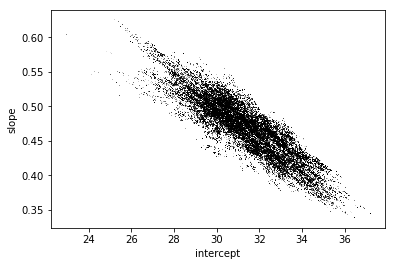

In [13]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

We see a distribution of points near a slope of $\sim 0.45$, and an intercept of $\sim 31$. We'll plot this model over the data below, but first let's see what other information we can extract from this trace.

One nice feature of analyzing MCMC samples is that the choice of nuisance parameters is completely symmetric: just as we can treat the $\{g_i\}$ as nuisance parameters, we can also treat the slope and intercept as nuisance parameters! Let's do this, and check the posterior for $g_1$ and $g_2$, the outlier flag for the first two points:

g1 mean: 0.59
g2 mean: 0.35


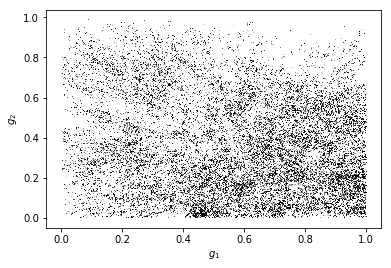

In [14]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

There is not an extremely strong constraint on either of these, but we do see that $(g_1, g_2) = (1, 0)$ is slightly favored: the means of $g_1$ and $g_2$ are greater than and less than 0.5, respecively. If we choose a cutoff at $g=0.5$, our algorithm has identified $g_2$ as an outlier.

Let's make use of all this information, and plot the marginalized best model over the original data. As a bonus, we'll draw red circles to indicate which points the model detects as outliers:

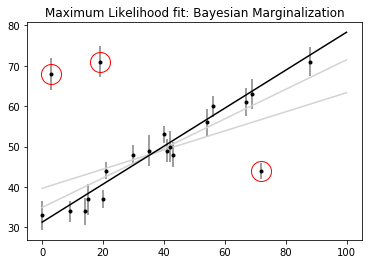

In [15]:
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.5)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');

The result, shown by the dark line, matches our intuition! Furthermore, the points automatically identified as outliers are the ones we would identify by hand.  For comparison, the gray lines show the two previous approaches: the simple maximum likelihood and the frequentist approach based on Huber loss.

### Discussion

Here we've dived into linear regression in the presence of outliers. A typical Gaussian maximum likelihood approach fails to account for the outliers, but we were able to correct this in the frequentist paradigm by modifying the loss function, and in the Bayesian paradigm by adopting a mixture model with a large number of nuisance parameters.

Both approaches have their advantages and disadvantages: the frequentist approach here is relatively straightforward and computationally efficient, but is based on the use of a loss function which is not particularly well-motivated. The Bayesian approach is well-founded and produces very nice results, but requires a rather subjective specification of a prior. It is also much more intensive in both coding time and computational time.

## Conclusion... for now

### Frequentist Analysis: Apply with Care

We started with a discussion of the philosophical differences between frequentism and Bayesianism, and showed that, despite these differences, they often give the same result for simple problems. Here we've explored one category of problem where the results begin to diverge: accounting for nuisance parameters.

For Bayes' billiard ball example, we showed that a naïve frequentist approach leads to the wrong answer, while a naïve Bayesian approach leads to the correct answer. This doesn't mean frequentism is wrong, but it does mean we ***must be very careful when applying it***.

### Bayesian Analysis: Cognitively Simple, Computationally Expensive

For the linear regression example, we showed one possible approach from both frequentism and Bayesianism for accounting for outliers in our data.

Using a robust frequentist cost function is relatively fast and painless, but is dubiously motivated and leads to results which are difficult to interpret.

Using a Bayesian mixture model takes more effort and requires more intensive computation, but leads to a very nice result in which multiple questions can be answered at once: in this case, marginalizing one way to find the best-fit model, and marginalizing another way to identify outliers in the data.

### Which Approach is Better?

The answer probably depends on your level of expertise in frequentist and Bayesian methods, as well as the size of your problem and your available computational resources. Applied appropriately, frequentist analyses can give correct results at typically smaller computational expense.

***But with Bayesianism, based on algebraic manipulation of a few probability axioms, we can construct extremely flexible methods to address a wide variety of problems.*** Just as the conservation of mass-energy can be applied to everything from projectile motion to stellar structure, Bayes' rule and the Bayesian probability interpretation can be applied to solve virtually any statistical problem: from computing gambling odds to detecting exoplanet transits in noisy photometric data.

In a Bayesian paradigm, you need not spend years memorizing and understanding obscure frequentist techniques and jargon (p-values, null tests, confidence intervals, breakdown points, etc.) in order to do such nontrivial analyses. 

***It's a common misconception: people imagine that Bayesian analysis is hard. On the contrary, many scientists use it just because it's easy!***

### Why "Bayesian" is the Correct Answer

Ease and aesthetics aside, though, there's a further important reason to sit firmly in the Bayesian camp, and that has to do with the interpretation of frequentist confidence intervals and Bayesian credibility regions within the context of scientific data.

We look at that next.